<img align="center" src="http://sydney.edu.au/images/content/about/logo-mono.jpg">
<h1 align="center" style="margin-top:10px">Statistical Learning with Python</h1>
<h2 align="center" style="margin-top:20px">Lecture 7: Decision Trees and Random Forests</h2>
<br>


<a href="#1.-German-Credit-Risk-Data">German Credit Risk Data</a> <br>
<a href="#2.-Decision-Analysis">Decision Analysis</a> <br>
<a href="#3.-Exploratory-Data-Analysis">Exploratory Data Analysis</a> <br>
<a href="#4.-Feature-Engineering">Feature Engineering</a> <br>
<a href="#5.-Decision-Tree">Decision Tree</a> <br>
<a href="#6.-Bagging">Bagging</a> <br>
<a href="#7.-Random-Forest">Random Forest</a> <br>
<a href="#8.-Model-Evaluation">Model Evaluation</a> <br>

This notebook relies on the following libraries and settings.

In [1]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') 

In [2]:
# Plot settings
sns.set_context('notebook') # optimises figures for notebook display
sns.set_style('ticks') # set default plot style
crayon = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', 
          '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(crayon) # set custom color scheme
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

In [3]:
# Methods
from sklearn.linear_model import LogisticRegression

# Model selection and evaluation tools
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_predict
from skopt.space import Real, Categorical, Integer
from skopt import BayesSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, average_precision_score, log_loss

### 1. German Credit Risk Data

**1.1 Loading the Data**

In [4]:
data = pd.read_csv('Data/german_credit.csv')
data.head()

,status,duration,history,purpose,amount,savings,employment,installment_rate,personal,other_debtors,...,property,age,other_installment_plans,housing,existing_credits,job,people_under_maintenance,telephone,foreign_worker,default
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,1,1,0
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,0,1,1
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,0,1,0
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,0,1,0
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,0,1,1


There are 13 categorical predictors (two of them binary and already coded numerically) and 7 numerical predictors in the dataset. Refer to the documentation for the explanation of the variables and the meaning of the values for the categorical variables. 

In [5]:
variables = pd.read_csv('Data/german_credit_variables.csv', index_col='variable')
variables = variables['type']

continuous = variables[variables == 'continuous'].index.tolist()
discrete = variables[variables == 'discrete'].index.tolist()
categorical = variables[variables == 'categorical'].index.tolist()
binary = variables[variables == 'binary'].index.tolist()
response = variables[variables == 'response'].index.tolist()
   
variables.value_counts()

categorical    11
discrete        4
continuous      3
binary          2
response        1
Name: type, dtype: int64

**1.2 Data Splitting**

As always, we need to split the data before exploratory data analysis. For now we only need to create the unprocessed training dataset. 

In [6]:
index_train, index_test  = train_test_split(np.array(data.index), stratify=data[response], 
                                            train_size=0.7, random_state=5)
train = data.loc[index_train,:].copy()

### 2. Decision Analysis

The dataset description specifies the loss matrix as follows: if we predict a default but the customer is a good credit, the loss is one.  If we predict that the customer is a good credit but there is a default, the loss is 5. The loss for a correct classification is zero. 

In the terminology of the lectures, the loss from a false positive is 1, the loss from a false negative is 5, and the loss from true positives and true negatives is zero. 

Using the formula from the lectures, the decision threshould therefore is: 

In [7]:
tau = 1/(1+5)
print(f'Decision threshold: tau={round(tau,3)}')

Decision threshold: tau=0.167


### 3. Exploratory Data Analysis

We have 30% of observations in the training data correspond to defaults. 

In [8]:
train['default'].value_counts(normalize=True)

0    0.7
1    0.3
Name: default, dtype: float64

The descriptive statistics allows us to verify that there are no missing values or apparent errors in the numerical variables.

In [9]:
train.describe().round(2)

,duration,amount,installment_rate,residence,age,existing_credits,people_under_maintenance,telephone,foreign_worker,default
count,700.00,700.00,700.00,700.00,700.00,700.00,700.00,700.00,700.00,700.00
mean,21.12,3346.50,2.97,2.84,35.67,1.43,1.16,0.41,0.97,0.30
std,12.26,2870.26,1.13,1.11,11.60,0.59,0.37,0.49,0.18,0.46
min,4.00,250.00,1.00,1.00,20.00,1.00,1.00,0.00,0.00,0.00
25%,12.00,1364.00,2.00,2.00,27.00,1.00,1.00,0.00,1.00,0.00
50%,18.00,2339.50,3.00,3.00,33.00,1.00,1.00,0.00,1.00,0.00
75%,24.00,4151.50,4.00,4.00,42.00,2.00,1.00,1.00,1.00,1.00
max,60.00,15945.00,4.00,4.00,75.00,4.00,2.00,1.00,1.00,1.00


As common in this type of data, some of the continuous variables are skewed. 

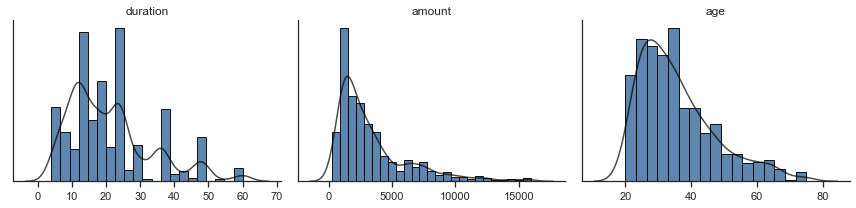

In [10]:
from statlearning import distplots
distplots(train[continuous]) 
plt.show()

The duration and amount of the loan seem to have a relevant positive association with the default rates.

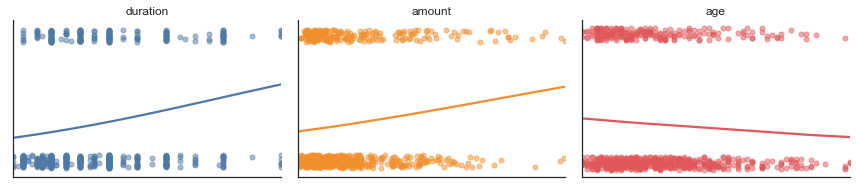

In [11]:
from statlearning import plot_logistic_regressions
fig, ax = plot_logistic_regressions(train[continuous], train['default'])
plt.show()

The following bar plots allow us to visualise the relationship between defaults and the remaining variables. Certain variables, such as the status of existing checking account, saving, credit history, and whether the client is a foreign worker seem to have an important association with default rates.

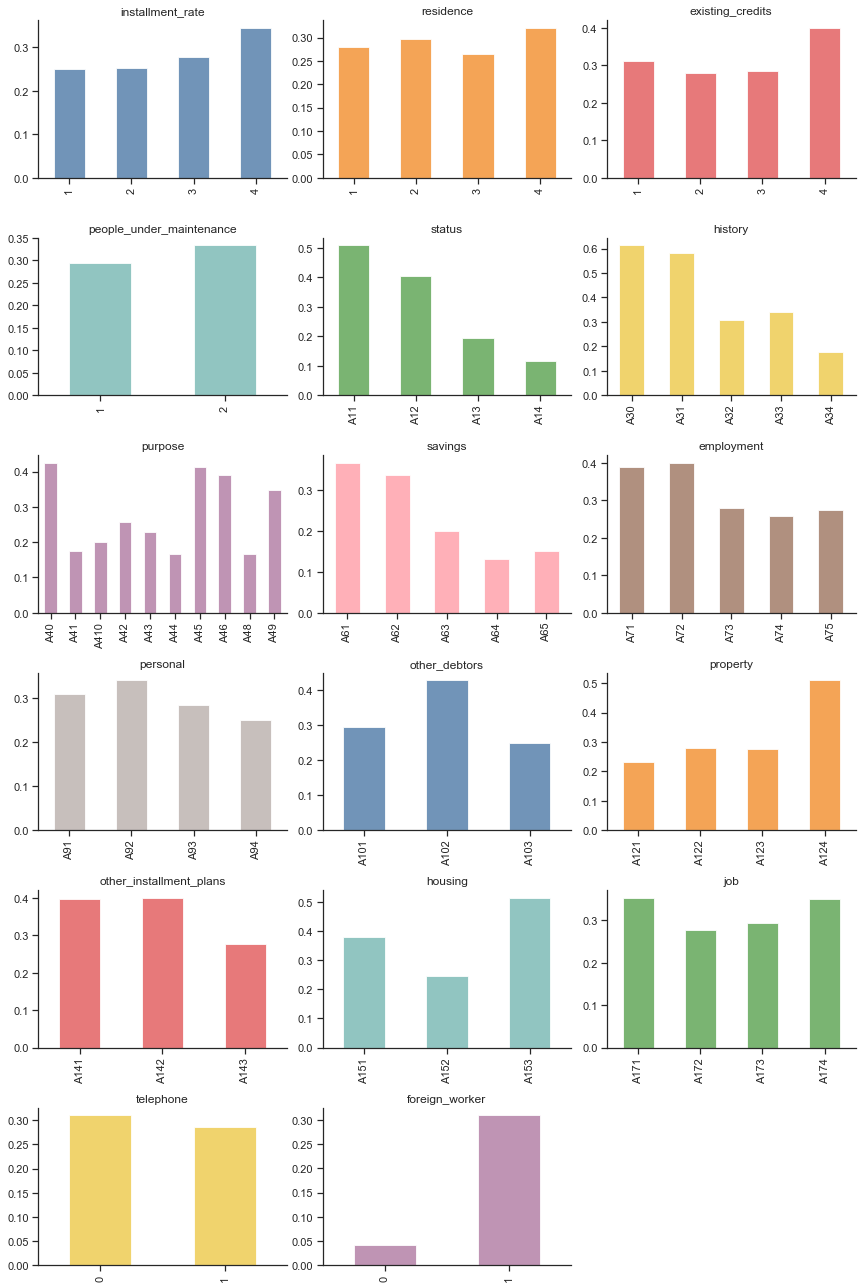

In [14]:
from statlearning import crosstabplots
crosstabplots(train[discrete + categorical + binary], train['default'])
plt.show()

### 4. Feature Engineering

**4.1 Tree-based methods**

As mentioned in the lectures, we generally want to process the data in a specialised way for tree-based methods. Based on the variable descriptions, some of the predictors are ordinal. We use ordinal encoding for these variables (it's useful to confirm that this makes sense using the EDA plots). The other categorical variables are nominal, such that we apply one-hot encoding. 

We code this process as follows.

In [15]:
def feat_engineering_tree(original_data, variables, index_train, index_test):
    
    data = original_data.copy()
    
    continuous = variables[variables == 'continuous'].index.tolist()
    discrete = variables[variables == 'discrete'].index.tolist()
    ordinal = []
    binary = variables[variables == 'binary'].index.tolist()
    response = variables[variables == 'response'].index.values[0]
   
    # Status of existing checking account (nominal -> ordinal encoding)
    label = 'status'
    keys = {
    'A11': 1,
    'A12': 2,
    'A13': 3,
    'A14': 4,
    }
    data[label] = (data[label].replace(keys)).astype(int)
    ordinal.append(label)
    
     # Savings accounts/bonds (nominal -> ordinal encoding)
    label = 'savings'
    keys = {
    'A61': 1,
    'A62': 2,
    'A63': 3,
    'A64': 4,
    'A65': 0,
    }
    data[label] = (data[label].replace(keys)).astype(int)
    ordinal.append(label)
    
    # Job (nominal -> ordinal encoding)
    label = 'job'
    keys = {
    'A171': 1,
    'A172': 2,
    'A173': 3,
    'A174': 4,
    }
    data[label] = (data[label].replace(keys)).astype(int)
    ordinal.append(label)

    # Credit History (nominal -> ordinal encoding)
    label = 'history'
    data[label] = data[label].str[-1].astype(int)
    ordinal.append(label)
    
    # Present employment since(nominal -> ordinal encoding)
    label = 'employment'
    data[label] = data[label].str[-1].astype(int)
    
     # Property (nominal -> ordinal encoding)
    label = 'property'
    data[label] = np.abs(data[label].str[-1].astype(int)-4)
    ordinal.append(label)

    # nominal -> one-hot encoding
    labels = ['purpose', 'personal', 'other_debtors', 'other_installment_plans', 'housing']
    for label in labels:
        dummies = pd.get_dummies(data[label], prefix=label)
        data=data.join(dummies)
        binary += list(dummies.columns)
    
    # Constructing the final dataset
    predictors =  continuous + discrete + ordinal + binary
    X_train = data.loc[index_train, predictors].to_numpy()
    X_test = data.loc[index_test, predictors].to_numpy()

    y_train = data.loc[index_train, response].to_numpy()
    y_test = data.loc[index_test, response].to_numpy()
    
    return X_train, y_train, X_test, y_test, predictors

Running the function prepares the dataset for the tree-based methods. 

In [16]:
X_train, y_train, X_test, y_test, predictors = feat_engineering_tree(data, variables, index_train, index_test)

**4.2 Logistic Regression**

The feature engineering processing needs to be different for a logistic regression, which we will adopt as a benchmark. In this case, we use dummy encoding for all the discrete and categorical (ordinal and nominal) variables. There is no one-hot encoding to avoid perfect multicollinearity.

Furthermore, we consider a Yeo-Johnson transformation of the credit amount (recall that this is unnecessary for the tree-based methods, which are invariant to monotonic transformations of the inputs). 

In [17]:
from sklearn.preprocessing import PowerTransformer, StandardScaler

def feat_engineering_logistic(original_data, variables, index_train, index_test):
    
    data = original_data.copy()
    
    continuous = variables[variables == 'continuous'].index.tolist()
    discrete = variables[variables == 'discrete'].index.tolist()
    categorical = variables[variables == 'categorical'].index.tolist()
    binary = variables[variables == 'binary'].index.tolist()
    response = variables[variables == 'response'].index.tolist()
    
    # Dummy encoding for all discrete and categorical variables
    labels = discrete + categorical 
    for label in labels:
        dummies = pd.get_dummies(data[label], prefix=label, drop_first=True)
        data=data.join(dummies)
        binary += list(dummies.columns)
    
    # Note that we fit the Yeo-Johnson transformation based only on the training data.
    # Otherwise, we'd be doing semi-supervised, not supervised learning. 
    # For a Kaggle competition, however, it's ok (in fact better) to do semi-supervised. 
    transf = PowerTransformer(method='yeo-johnson').fit(data.loc[index_train, ['amount']])
    data['amount'] = transf.transform(data[['amount']])
    
    predictors = continuous + binary
    scaler = StandardScaler().fit(data.loc[index_train, predictors])
    data[predictors] = scaler.transform(data[predictors])
    
    X_train = data.loc[index_train, predictors].to_numpy()
    X_test = data.loc[index_test, predictors].to_numpy()

    y_train = data.loc[index_train, response].to_numpy()
    y_test = data.loc[index_test, response].to_numpy()
    
    return X_train, y_train, X_test, y_test

X_train_logit, _, X_test_logit, _ = feat_engineering_logistic(data, variables, index_train, index_test)

### 5. Decision Tree

The basic syntax for fitting a classification tree is as follows. We start with a small tree for visualisation.

In [18]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(criterion='entropy', max_depth=2)
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

The next cell allows us to visualise the fitted tree.

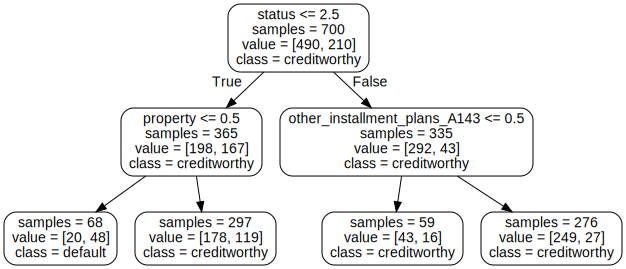

In [19]:
# You'd need to find the Graphviz path for your computer
import os
os.environ['PATH'] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

import graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(tree, out_file=None , impurity=False, feature_names = predictors,
                           class_names=['creditworthy','default'], rounded=True) 
graph = graphviz.Source(dot_data)
graph.render('tree01') # saves tree to a file
graph

In [20]:
%%time

model = DecisionTreeClassifier(criterion='entropy')

tuning_parameters = {
    'min_samples_leaf': [1,5,10,20,30,40,50,60,70,80],
    'min_samples_split' : [2,4,8,16,32,64],
}

tree_search = GridSearchCV(model, tuning_parameters, cv = 5 , scoring='neg_log_loss')
tree_search.fit(X_train, y_train)

tree = tree_search.best_estimator_

print('Best parameters found by grid search:', tree_search.best_params_, '\n')

Best parameters found by grid search: {'min_samples_leaf': 70, 'min_samples_split': 2} 

Wall time: 792 ms


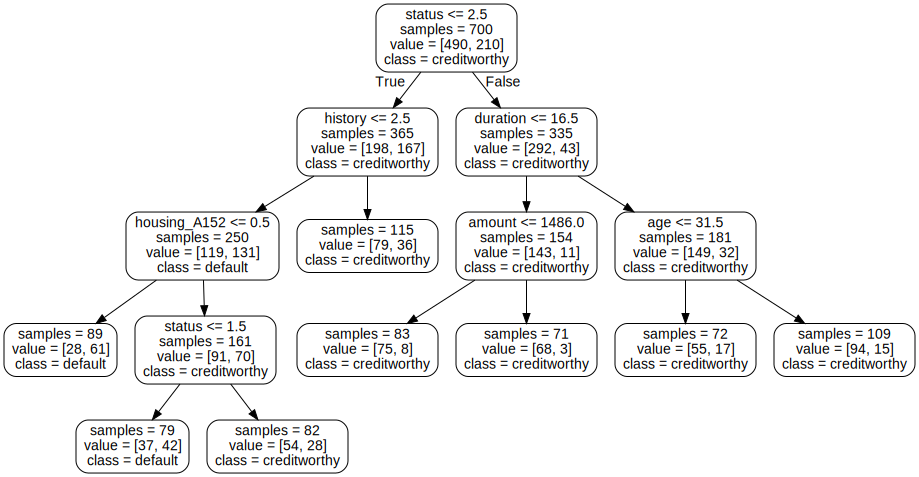

In [21]:
dot_data = export_graphviz(tree, out_file=None , impurity=False, feature_names = predictors,
                           class_names=['creditworthy','default'], rounded=True) 
graph = graphviz.Source(dot_data)
graph.render('tree02') # saves tree to a file
graph

### 6. Bagging

In [22]:
from sklearn.ensemble import BaggingClassifier
bag = BaggingClassifier(DecisionTreeClassifier(criterion='entropy'), n_estimators=1000, random_state=1)
bag.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=1000, n_jobs=None, oob_score=False,
         random_state=1, verbose=0, warm_start=False)

### 7. Random Forest

The syntax to fit a [random forest classifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) is the following. 

In [23]:
from sklearn.ensemble import  RandomForestClassifier
rf = RandomForestClassifier(criterion='entropy', max_features= 2, min_samples_leaf=5, 
                            n_estimators=1000, random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

To tune the random forest, we should select a parameter that controls the size of the trees (such as the minimum number of observations in the leaves) and the number of predictors that are sampled as candidate split variables at each node of a tree.  

In [32]:
%%time

model = RandomForestClassifier(criterion = 'entropy',  n_estimators=1000)

tuning_parameters = {
    'min_samples_leaf': [1, 5, 10, 20, 50],
    'max_features': np.arange(1, X_train.shape[1]),
}

rf_search = RandomizedSearchCV(model, tuning_parameters, cv = 5, n_iter= 128, n_jobs=4, 
                               scoring='neg_log_loss', random_state=1)
rf_search.fit(X_train, y_train)

rf = rf_search.best_estimator_

print('Best parameters found by randomised search:', rf_search.best_params_, '\n')

Best parameters found by randomised search: {'min_samples_leaf': 1, 'max_features': 9} 

Wall time: 3min 15s


After tuning the random forest, we may want to increase the number of trees to improve accuracy. 

In [33]:
rf.n_estimators = 10000
rf.random_state = 1
rf.fit(X_train, y_train) 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=9, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

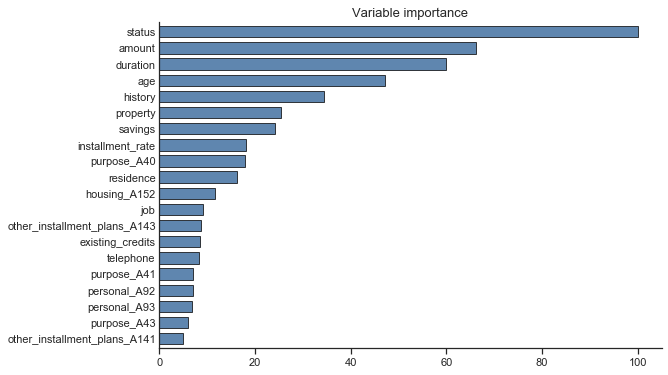

In [26]:
from statlearning import plot_feature_importance

plot_feature_importance(rf, predictors)
plt.show()

### 8. Model Evaluation

Our benchmark will be the logistic regression model:

In [27]:
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(C=np.inf, solver='lbfgs')
logit.fit(X_train_logit, y_train)

from sklearn.linear_model import LogisticRegressionCV

logit_l1= LogisticRegressionCV(Cs = 50, penalty='l1', solver='liblinear', scoring='neg_log_loss')
logit_l1.fit(X_train_logit, y_train)

logit_l2= LogisticRegressionCV(Cs = 50, penalty='l2', solver='lbfgs', scoring='neg_log_loss')
logit_l2.fit(X_train_logit, y_train)

LogisticRegressionCV(Cs=50, class_weight=None, cv='warn', dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring='neg_log_loss',
           solver='lbfgs', tol=0.0001, verbose=0)

We find that the random forests leads to substantial reduction in the average loss compared to the other methods. The key reason for this is that it has better sensitivity than other methods (that is, it correctly classifies more defaults), without performing substantially worse in terms of specificity (that is, it does not have too many false positives). 

In [34]:
columns=['Loss', 'Sensitivity', 'Specificity', 'AUC', 'Precision']
rows=['Logistic', 'Logistic $\ell_1$', 'Logistic $\ell_2$', 'Decision Tree', 'Bagged trees', 'Random forest']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[logit, logit_l1, logit_l2, tree, bag, rf]

y_prob = np.zeros((len(y_test), len(rows)))

for i, method in enumerate(methods):
    
    if i<=2:
        y_prob[:, i] = method.predict_proba(X_test_logit)[:,1]
    else: 
        y_prob[:, i] = method.predict_proba(X_test)[:,1]

    y_pred = (y_prob[:, i]>tau).astype(int)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel() 

    results.iloc[i,0]=  (fp*1+fn*5)/len(y_test)
    results.iloc[i,1]=  tp/(tp+fn)
    results.iloc[i,2]=  tn/(tn+fp)
    results.iloc[i,3]=  roc_auc_score(y_test, y_prob[:,i])
    results.iloc[i,4]=  precision_score(y_test, y_pred)
   

results.round(3)

,Loss,Sensitivity,Specificity,AUC,Precision
Logistic,0.687,0.767,0.519,0.733,0.406
Logistic $\ell_1$,0.603,0.878,0.400,0.742,0.385
Logistic $\ell_2$,0.650,0.844,0.405,0.746,0.378
Decision Tree,0.653,0.844,0.400,0.687,0.376
Bagged trees,0.607,0.856,0.443,0.751,0.397
Random forest,0.537,0.911,0.424,0.752,0.404


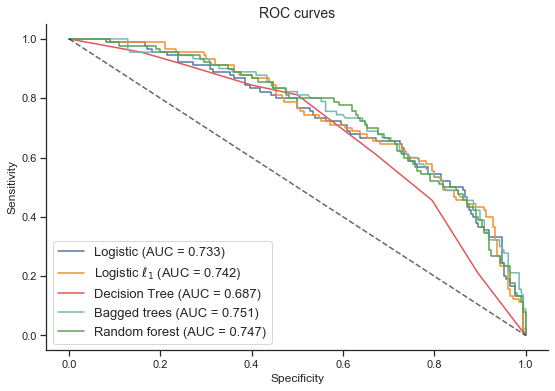

In [29]:
from statlearning import plot_roc_curves

fig, ax = plot_roc_curves(y_test, y_prob[:,[0,1,3,4,5]], labels=pd.Series(rows).iloc[[0,1,3,4,5]])
plt.show()

### 9. Exercises

If you're looking for a challenge:

(a) Experiment with variations on the feature engineering. For example, the status predictor was the most important variable for the random forest. What happens if you try one-hot encoding instead of ordinal encoding for this variable?

(b) Experiment with [probability calibration](https://scikit-learn.org/stable/modules/calibration.html#calibration). You can the [CalibratedClassifierCV](https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html#sklearn.calibration.CalibratedClassifierCV) class for this.

(c) Analyse the [reliability curves](https://scikit-learn.org/stable/modules/generated/sklearn.calibration.calibration_curve.html#sklearn.calibration.calibration_curve) for different methods.


Use the test set from the previous sections as a validation set for these exercises.

### Formatting

These two cells below format the notebook for display online. Please omit them from your work.

In [30]:
%%html
<style>
@import url('https://fonts.googleapis.com/css?family=Source+Sans+Pro|Open+Sans:800&display=swap');
</style>

In [31]:
from IPython.core.display import HTML
style = open('jstyle.css', "r").read()
HTML('<style>'+ style +'</style>')